In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.figsize"] = (11, 6) 

In [2]:
df = pd.read_csv("data/credit_card_data.csv")
df.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5


In [3]:
df.describe(include="object")

,card,owner,selfemp
count,1319,1319,1319
unique,2,2,2
top,yes,no,no
freq,1023,738,1228


In [4]:
df.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [5]:
df["target"] = df.card.map({'yes':1, 'no':0})
df.tail()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
1314,yes,0,33.58333,4.566,0.002146,7.333333,yes,no,0,94,1,19,1
1315,no,5,23.91667,3.192,0.000376,0.000000,no,no,3,12,1,5,0
1316,yes,0,40.58333,4.600,0.026513,101.298300,yes,no,2,1,1,2,1
1317,yes,0,32.83333,3.700,0.008999,26.996670,no,yes,0,60,1,7,1
1318,yes,0,48.25000,3.700,0.111619,344.157500,yes,no,2,2,1,0,1


In [6]:
# del df['card']
df_full_train, df_test, y_full_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=1)
df_train, df_valid, y_train, y_valid = train_test_split(df_full_train, df_full_train.target, test_size=0.25, random_state=1)
df_full_train.head(3)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
710,no,1,36.83333,3.0000,0.000400,0.000000,yes,no,1,12,1,16,0
1258,yes,0,35.58333,3.5606,0.109084,323.587500,no,no,0,12,1,0,1
435,yes,0,25.66667,2.0000,0.004900,7.416667,no,no,0,26,1,13,1


---
## Question 1
Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`
---

In [7]:
num_cols = list(df.columns[df.dtypes != 'object'])
cat_cols = list(df.columns[df.dtypes == 'object'])

model = LogisticRegression()
for col in num_cols:
    if col == "target":
        continue
    
    model.fit(df_train[col].values.reshape(-1, 1), y_train)
    probs = model.predict_proba(df_train[[col]].values.reshape(-1, 1))[:,1]
    score = roc_auc_score(y_train, probs)
    print("Column: %12s -> %0.3f" %(col, score))

Column:      reports -> 0.717
Column:          age -> 0.524
Column:       income -> 0.591
Column:        share -> 0.989
Column:  expenditure -> 0.991
Column:   dependents -> 0.533
Column:       months -> 0.529
Column:   majorcards -> 0.534
Column:       active -> 0.604


## Training the model
From now on, use these columns only:
```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```
Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:
```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```


---
## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995
---

In [8]:
predictors = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", 
              "owner", "selfemp"]

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

oneHotEncoder = DictVectorizer(sparse=False)

def encode( df_train : pd.DataFrame(), df_valid : pd.DataFrame , predictors : list()):
    """One Hot encoding of two dataframes using DictVectorizer
    Inputs: 
    df_train   : train dataset, a pandas dataframe
    df_valid   : validation dataset, a pandas dataframe
    predictors : a list of column names / features to use
    Outputs:
    X_train : One hot encoded 2D train data array
    X_valid : One hot encoded 2D validation data array"""
    oneHotEncoder = DictVectorizer(sparse=False)
    records = df_train[predictors].to_dict(orient='records')
    X_train = oneHotEncoder.fit_transform(records)
    X_valid = oneHotEncoder.transform(df_valid[predictors].to_dict(orient='records'))
    return X_train, X_valid

X_train, X_valid = encode(df_train, df_valid, predictors)
model.fit(X_train, y_train)
y_train_prob =model.predict_proba(X_train)[:,1]
y_val_prob =model.predict_proba(X_valid)[:,1]

print( "ROC_AUC score for training is %.3f" %roc_auc_score(y_train, y_train_prob))
print( "ROC_AUC score for validation is %.3f" %roc_auc_score(y_valid, y_val_prob))

ROC_AUC score for training is 0.998
ROC_AUC score for validation is 0.995


---
## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8
---

In [9]:
# We could use sklearn metric functions but lets define the scores ourselves
def precision_score(y_observed, y_predicted):
    TP = (y_predicted & y_observed)
    return sum(TP) / sum(y_predicted)

def recall_score(y_observed, y_predicted):
    TP = (y_predicted & y_observed)
    return sum(TP) / sum(y_observed)

0.24
0.25
0.26
0.27
0.28
0.29


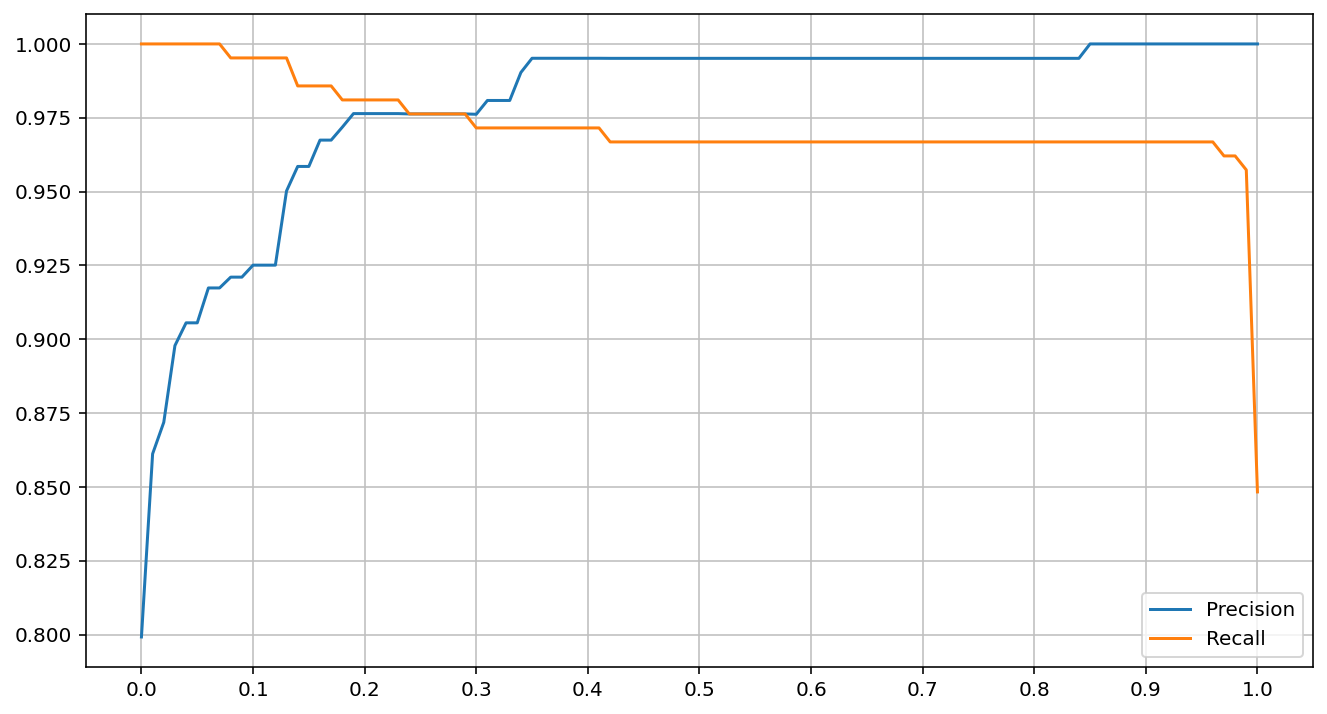

In [10]:
precision_scores = []
recall_scores = []
f1_scores = []

for t in (t_range:=np.arange(0, 1.01, 0.01)):
    preds = y_val_prob >= t
    p = precision_score(y_valid, preds)
    r = recall_score(y_valid, preds)
    precision_scores.append(p)
    recall_scores.append(r)
    f1_scores.append( 2*p*r/(p+r) )
    if p==r:    # you may prefer to use np.isclose() with tolerances here
        print(t)
    
plt.plot(np.arange(0, 1.01, 0.01), precision_scores)
plt.plot(np.arange(0, 1.01, 0.01), recall_scores)
plt.grid(color='0.75')
plt.xticks(ticks=np.arange(0,1.001, 0.1))
plt.legend(["Precision", "Recall"])
plt.show();

---
## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7
---

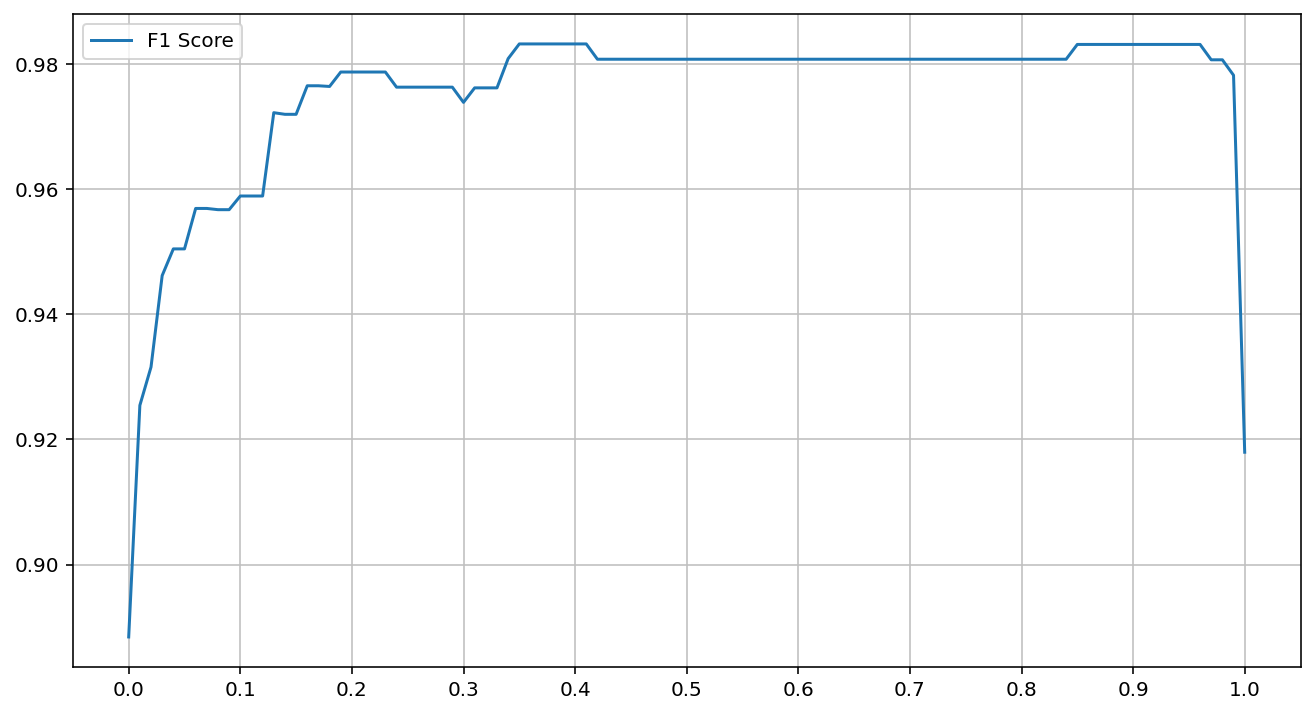

In [11]:
plt.plot(np.arange(0, 1.01, 0.01), f1_scores)
plt.legend(["F1 Score"])
plt.grid(color='0.75')
plt.xticks(ticks=np.arange(0,1.001, 0.1))
plt.show()

In [12]:
np.round(0.01 * f1_scores.index(max(f1_scores)), 2)

0.35

In [13]:
f1_scores.reverse()
np.round(1 - 0.01 * f1_scores.index(max(f1_scores)), 2)

0.41

We can see that the max values are in range from 0.35 to 0.41.

---
## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24
---

In [14]:
KF = KFold(n_splits=5, shuffle=True, random_state=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
auc_scores = []

for train_idx, valid_idx in KF.split(df_full_train[predictors]):
    X_train = df_full_train[predictors].iloc[train_idx]
    X_valid = df_full_train[predictors].iloc[valid_idx]
    X_train, X_valid = encode(X_train, X_valid, predictors)
    y_train = y_full_train.iloc[train_idx]
    y_valid = y_full_train.iloc[valid_idx]
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred_prob)
    auc_scores.append(score)

np.array(auc_scores).std().round(3)

0.003

---
## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

---

In [15]:
scores = dict()
stdevs = dict()
for c_val in [0.01, 0.1, 1, 10]:
    auc_scores = []
    model = LogisticRegression(solver='liblinear', C=c_val, max_iter=1000)
    for train_idx, valid_idx in KF.split(df_full_train[predictors]):
        X_train = df_full_train[predictors].iloc[train_idx]
        X_valid = df_full_train[predictors].iloc[valid_idx]
        X_train, X_valid = encode(X_train, X_valid, predictors)
        y_train = y_full_train.iloc[train_idx]
        y_valid = y_full_train.iloc[valid_idx]
        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_valid)[:,1]
        score = roc_auc_score(y_valid, y_pred_prob)
        auc_scores.append(score)
    scores[c_val] = np.mean(auc_scores)
    stdevs[c_val] = np.std(auc_scores)

score_df = pd.DataFrame(scores.values(),  index=[str(k) for k in scores.keys()], columns=["score"])
std_df = pd.DataFrame(stdevs.values(),  index=[str(k) for k in stdevs.keys()], columns=["std"])

result_df = pd.concat([score_df, std_df], axis=1)
result_df.head()

,score,std
0.01,0.991881,0.005599
0.1,0.995056,0.003954
1,0.996450,0.002743
10,0.996389,0.002815


In [16]:
results = result_df.round(3)
results["c"] = results.index
results_sorted = results.sort_values(["score", "std", "c"], ascending=[False, True, True]).reset_index(drop=True)
results_sorted

,score,std,c
0,0.996,0.003,1
1,0.996,0.003,10
2,0.995,0.004,0.1
3,0.992,0.006,0.01


In [17]:
results_sorted.loc[0,"c"]

'1'

---
The end of the Week 4 Assignment

---